In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# load dependencies
import sys
import pickle
import os
import shutil
import json
import pandas as pd
import numpy as np
import rdkit.Chem as Chem
from numpy.random import default_rng
import torch
from ast import literal_eval
from torch import nn, optim
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc import Oracle
import subprocess

In [64]:
print(os.getcwd())

/home/springnuance/reinvent-hitl/Base-Code-Binh


In [75]:
from training_Bradley_Terry_model.bradley_terry import BradleyTerryModel
from training_Rank_ListNet_model.rank_listnet import RankListNetModel
from training_Score_Regression_model.score_regression import ScoreRegressionModel
from helper import load_drd2_dataset, write_REINVENT_config, change_config_json, \
                    read_scaffold_result, load_feedback_model, smiles_human_score, \
                    compute_fingerprints, retrain_feedback_model,\
                    create_drd2_dataset, combine_drd2_dataset, save_drd2_dataset
                        
from scripts.acquisition import select_query_feedback
from scripts.acquisition import predict_proba_from_model
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, matthews_corrcoef


def check_create(path):
    """
    Check if the directory exists, if not, create it.
    """
    if not os.path.exists(path):
        os.makedirs(path)
    
def evaluate_results(
        output_dir,
        feedback_type, # scoring, comparing, ranking
        final_testing_dataset_path, # path to the final training dataset
        model_pretrained_name, # Name of the pretrained model before REINVENT_round_1
        num_rounds, # number of rounds, corresponding to R in the paper
        num_iters, # number of iterations of showing molecules to the human for feedback at each round, corresponding to T in the paper
        num_queries, # number of molecules shown to the simulated chemist at each HITL_iteration
        acquisition, # acquisition: 'uncertainty', 'random', 'thompson', 'greedy' (if None run with no human interaction)
        sigma_noise, # noise level for simulated chemist's responses
):
    
    final_testing_dataset = pd.read_csv(final_testing_dataset_path)

    print("Loading final testing dataset successfully")
        
    smiles_test = final_testing_dataset['smiles'].to_numpy()
    label_test = final_testing_dataset['label'].to_numpy()
    
    analytics = {}
    
    # for score regression, dataset_outputs have columns: smiles, features, label_proba, label_binary
    # for bradley-terry, dataset_outputs have columns: smiles_1, smiles_2, features_1, features_2, 
                                                      # label_1_proba, label_2_proba, label_1_binary, label_2_binary
                                                      # compare_proba, compare_binary
    # for rank listnet, dataset_outputs have columns: smiles_1/2/3, features_1/2/3, label_1/2/3_proba, label_1/2/3_binary
                                                     # label_1/2/3_softmax, label_1/2/3_rank
    
    for REINVENT_round in range(1, num_rounds+1):
        reinvent_round_name = f"REINVENT_round_{REINVENT_round}"
        analytics[reinvent_round_name] = {}
        for HITL_iteration in range(1, num_iters+1):
            hitl_iteration_name = f"HITL_iteration_{HITL_iteration}"    

            metrics = {
                'thresholds': [],
                'TP': [], 'TN': [], 'FP': [], 'FN': [],
                'accuracy': [], 'precision': [], 'recall': [], 'F1': [], 'MCC': [],
            }

            feedback_model_path = f"{output_dir}/REINVENT_round_{REINVENT_round}/HITL_iteration_{HITL_iteration}/{model_pretrained_name}"

            if not os.path.exists(feedback_model_path):
                print(f"Feedback model {feedback_model_path} does not exist.")
            else:
                feedback_model = load_feedback_model(feedback_type=feedback_type, feedback_model_path=feedback_model_path)
                predicted_scores = predict_proba_from_model(feedback_type, feedback_model, smiles_test)
                
                # Compute metrics over a range of thresholds
                thresholds = np.linspace(0, 1, 101)
                for threshold in thresholds:
                    predicted_labels = (predicted_scores > threshold).astype(int)
                    TP = np.sum((predicted_labels == 1) & (label_test == 1))
                    TN = np.sum((predicted_labels == 0) & (label_test == 0))
                    FP = np.sum((predicted_labels == 1) & (label_test == 0))
                    FN = np.sum((predicted_labels == 0) & (label_test == 1))
                    
                    accuracy = (TP + TN) / len(label_test)
                    precision, recall, f1, _ = precision_recall_fscore_support(label_test, predicted_labels, average='binary')
                    mcc = matthews_corrcoef(label_test, predicted_labels)
                    
                    metrics['thresholds'].append(threshold)
                    metrics['TP'].append(TP)
                    metrics['TN'].append(TN)
                    metrics['FP'].append(FP)
                    metrics['FN'].append(FN)
                    metrics['accuracy'].append(accuracy)
                    metrics['precision'].append(precision)
                    metrics['recall'].append(recall)
                    metrics['F1'].append(f1)
                    metrics['MCC'].append(mcc)
        
                # Compute ROC curve and AUC
                fpr, tpr, _ = roc_curve(label_test, predicted_scores, pos_label=1)
                roc_auc = auc(fpr, tpr)

                metrics['fpr'] = fpr
                metrics['tpr'] = tpr
                metrics['roc_auc'] = roc_auc

                analytics[reinvent_round_name][hitl_iteration_name] = metrics
                    #print("accuracy: ", accuracy, "precision: ", precision, "recall: ", recall, "F1: ", f1, "MCC: ", mcc)
    return analytics

### Running score regression model

In [76]:
feedback_type = "scoring" 

# feedback type as scoring:
# Given a molecule, what is the probability that the molecule is active regarding DRD2?  

num_rounds = 3 # number of rounds, corresponding to R in the paper
num_iters = 5 # number of iterations of showing molecules to the human for feedback at each round
num_queries = 20 # number of molecules, pairs or a set of molecules, dependig on the task, 
                 # shown to the simulated chemist at each HITL_iteration

acquisition = "random"
sigma_noise = 0.0

# acquisition = "uncertainty"
# sigma_noise = 0.0

# acquisition = "greedy"
# sigma_noise = 0.0

# acquisition = "random"
# sigma_noise = 0.1

# acquisition = "uncertainty"
# sigma_noise = 0.1

# acquisition = "greedy"
# sigma_noise = 0.1

output_dir = f"output_score_regression/R{num_rounds}_T{num_iters}_Q{num_queries}_acq_{acquisition}_noise_{sigma_noise}"

# final_training_dataset_path = f"/home/springnuance/reinvent-hitl/Base-Code-Binh/{output_dir}/REINVENT_round_{num_rounds}/HITL_iteration_{num_iters}/iteration_combined_data.csv"
# base_testing_dataset_path = "/home/springnuance/reinvent-hitl/Base-Code-Binh/training_Score_Regression_model/small_drd2_testing_data.csv"

final_testing_dataset_path = "/home/springnuance/reinvent-hitl/Base-Code-Binh/data/drd2_final_test_small.csv"

model_pretrained_name = "score_regression_model.pth"

analytics = evaluate_results(
        output_dir,
        feedback_type, # scoring, comparing, ranking
        final_testing_dataset_path, # path to the final training dataset
        model_pretrained_name, # Name of the pretrained model before REINVENT_round_1
        num_rounds, # number of rounds, corresponding to R in the paper
        num_iters, # number of iterations of showing molecules to the human for feedback at each round, corresponding to T in the paper
        num_queries, # number of molecules shown to the simulated chemist at each HITL_iteration
        acquisition, # acquisition: 'uncertainty', 'random', 'thompson', 'greedy' (if None run with no human interaction)
        sigma_noise, # noise level for simulated chemist's responses
)


Loading final testing dataset successfully
Loading Score Regression model from output_score_regression/R3_T5_Q20_acq_random_noise_0.0/REINVENT_round_1/HITL_iteration_1/score_regression_model.pth
Loading Score Regression model from output_score_regression/R3_T5_Q20_acq_random_noise_0.0/REINVENT_round_1/HITL_iteration_2/score_regression_model.pth
Loading Score Regression model from output_score_regression/R3_T5_Q20_acq_random_noise_0.0/REINVENT_round_1/HITL_iteration_3/score_regression_model.pth
Loading Score Regression model from output_score_regression/R3_T5_Q20_acq_random_noise_0.0/REINVENT_round_1/HITL_iteration_4/score_regression_model.pth
Loading Score Regression model from output_score_regression/R3_T5_Q20_acq_random_noise_0.0/REINVENT_round_1/HITL_iteration_5/score_regression_model.pth
Loading Score Regression model from output_score_regression/R3_T5_Q20_acq_random_noise_0.0/REINVENT_round_2/HITL_iteration_1/score_regression_model.pth
Loading Score Regression model from output_sc

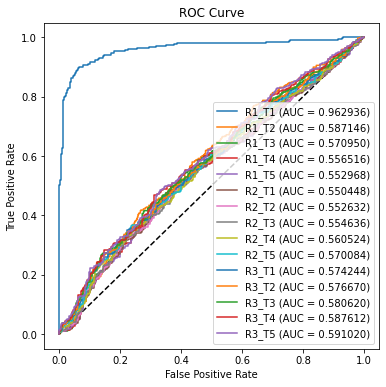

In [77]:
# print roc curves

# Data stored in metrics, fpr, tpr, roc_auc

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# draw a diagonal line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

chosen_models = [
                    ('REINVENT_round_3', 'HITL_iteration_5'),
                    ('REINVENT_round_3', 'HITL_iteration_4'),
                    ('REINVENT_round_3', 'HITL_iteration_3'),
                    ('REINVENT_round_3', 'HITL_iteration_2'),
                    ('REINVENT_round_3', 'HITL_iteration_1'),
                    ('REINVENT_round_2', 'HITL_iteration_5'),
                    ('REINVENT_round_2', 'HITL_iteration_4'),
                    ('REINVENT_round_2', 'HITL_iteration_3'),
                    ('REINVENT_round_2', 'HITL_iteration_2'),
                    ('REINVENT_round_2', 'HITL_iteration_1'),
                    ('REINVENT_round_1', 'HITL_iteration_5'),
                    ('REINVENT_round_1', 'HITL_iteration_4'),
                    ('REINVENT_round_1', 'HITL_iteration_3'),
                    ('REINVENT_round_1', 'HITL_iteration_2'),
                    ('REINVENT_round_1', 'HITL_iteration_1')
                    ]

for REINVENT_round in range(1, num_rounds + 1):
    for HITL_iteration in range(1, num_iters + 1):
        if (f"REINVENT_round_{REINVENT_round}", f"HITL_iteration_{HITL_iteration}") in chosen_models:
            fpr = analytics[f"REINVENT_round_{REINVENT_round}"][f"HITL_iteration_{HITL_iteration}"]['fpr']
            tpr = analytics[f"REINVENT_round_{REINVENT_round}"][f"HITL_iteration_{HITL_iteration}"]['tpr']
            roc_auc = analytics[f"REINVENT_round_{REINVENT_round}"][f"HITL_iteration_{HITL_iteration}"]['roc_auc']
            plt.plot(fpr, tpr, label=f"R{REINVENT_round}_T{HITL_iteration} (AUC = {roc_auc:.6f})")

plt.legend(loc='lower right')

### Running Bradley Terry model

In [68]:
base_testing_dataset_path = "/home/springnuance/reinvent-hitl/Base-Code-Binh/training_Bradley_Terry_model/small_drd2_testing_data.csv"

### Running Rank ListNet model

In [69]:
base_testing_dataset_path = "/home/springnuance/reinvent-hitl/Base-Code-Binh/training_Rank_ListNet_model/small_drd2_testing_data.csv"